# RAIL Onboarding 01: Navigation in a Known Grid

**Goal**: to create a very simple agent capable of reaching a goal in a known grid.

**Learning Objectives**:

- Learn how to create a basic procedural map
- Learn how to run our Unity visual simulator corresponding to the generated map
- Learn how to plan a trajectory in an occupancy grid and move a simulated robot towards a goal.

### Imports and Setup

There are a number of packages we will need and capabilities we will want to setup. The following code block imports the code used later on and defines a number of parameters that are often passed via a command line interface.

In [20]:
# Imports & Setup

import environments
import lsp
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import gridmap
import sys

print("Python Version and System Information")
print(sys.version)

# Set the arguments (usually done via the command line)
args = lambda: None
args.current_seed = 2010
args.map_type = 'office2'
args.unity_path = '/unity/rail_sim.x86_64'
args.save_dir = './'

# Robot Arguments
args.step_size = 1.8
args.num_primitives = 32
args.laser_scanner_num_points = 1024
args.field_of_view_deg = 360


Python Version and System Information
3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]


## Generating the map grid and planning in it

There are a few different procedural environments that ship with `lsp`. We will be using the `maze` environment for these tutorials (set via the arguments above), since they are reasonably simple yet already demonstrate the complexities in planning under uncertainty that motivate much of the research in the RAIL Group.

As defined in the arguments above, we will be using the `maze` environment type (`args.map_type = 'maze'`) with its default parameter values. We can by calling the function `environments.generate.map_and_poses`, which generates the map (a Numpy array `known_map`) and the map's metadata (the Python dictionary `map_data`). We then plot the grid:

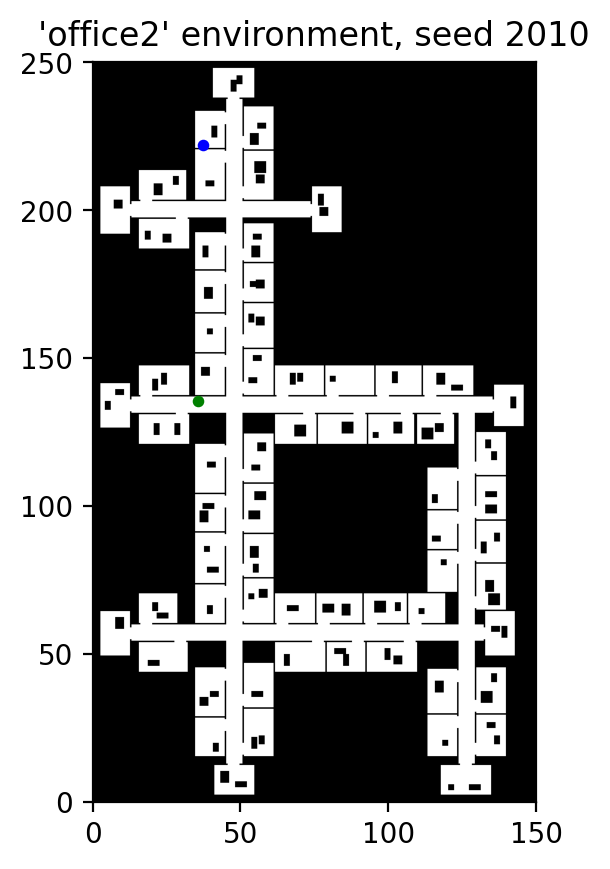

In [21]:
# Generate the map and relevant data

known_map, map_data, pose, goal = environments.generate.map_and_poses(args)

# Plotting
plt.figure(dpi=200)
lsp.utils.plotting.plot_navigation_data(
    plt.gca(), known_map, map_data=map_data, 
    robot_pose=args.base_resolution*pose, 
    goal_pose=args.base_resolution*goal)
plt.title(f"'{args.map_type}' environment, seed {args.current_seed}")
None

## Planning to the Goal

Planning in this grid is relatively easy using the functions built-into `gridmap.planning`. The following code generates a path (a series of waypoints) that the robot can follow to get from its starting position (blue) to the goal (green).

[[         inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf          inf
           inf          inf          inf          inf         

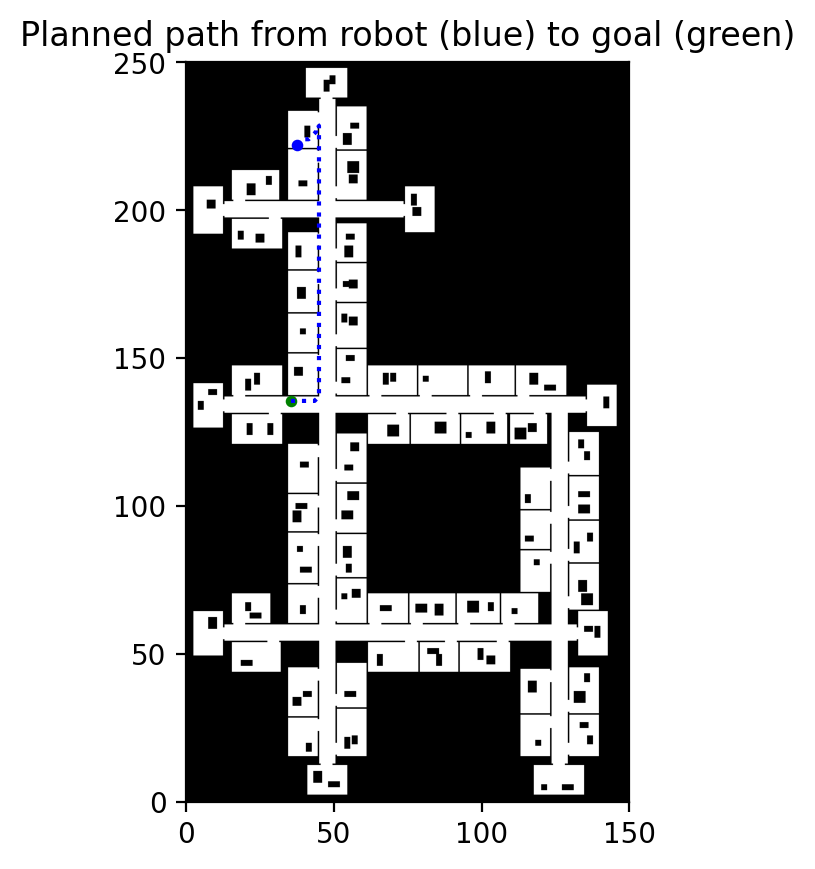

In [22]:
cost_grid, get_path = gridmap.planning.compute_cost_grid_from_position(
    known_map, [goal.x, goal.y])
did_plan, path = get_path([pose.x, pose.y])
np.set_printoptions(threshold=sys.maxsize)
print(cost_grid)
plt.figure(dpi=200)
lsp.utils.plotting.plot_navigation_data(
        plt.gca(), known_map, map_data=map_data, 
        robot_pose=args.base_resolution*pose,
        goal_pose=args.base_resolution*goal,
        planned_path=path)
plt.title("Planned path from robot (blue) to goal (green)")
None

Realistically, the robot is going to have some non-zero size, which will require that it plan to be at least somewhat far away from the walls. For this, we can include the inflation radius, which "inflates" (or "grows") the objects in the map so that it will plan farther around them. We also add a soft cost to the planner, which discourages being close to these newly inflated obstacles though does not outright prohibit it. We will also make the generated path sparser and "flipped" (so that the first point is the robot pose, rather than the other way around; this will be important later).

We will next inflate the grid, by a predefined amount `args.inflation_radius_m`, and replan with that grid to see how the plan changes so as to avoid being so close to obstacles. Notice how the grid and thus the path change.

Inflation Radius (meters): 0.75
Inflation Radius (grid units): 1.5


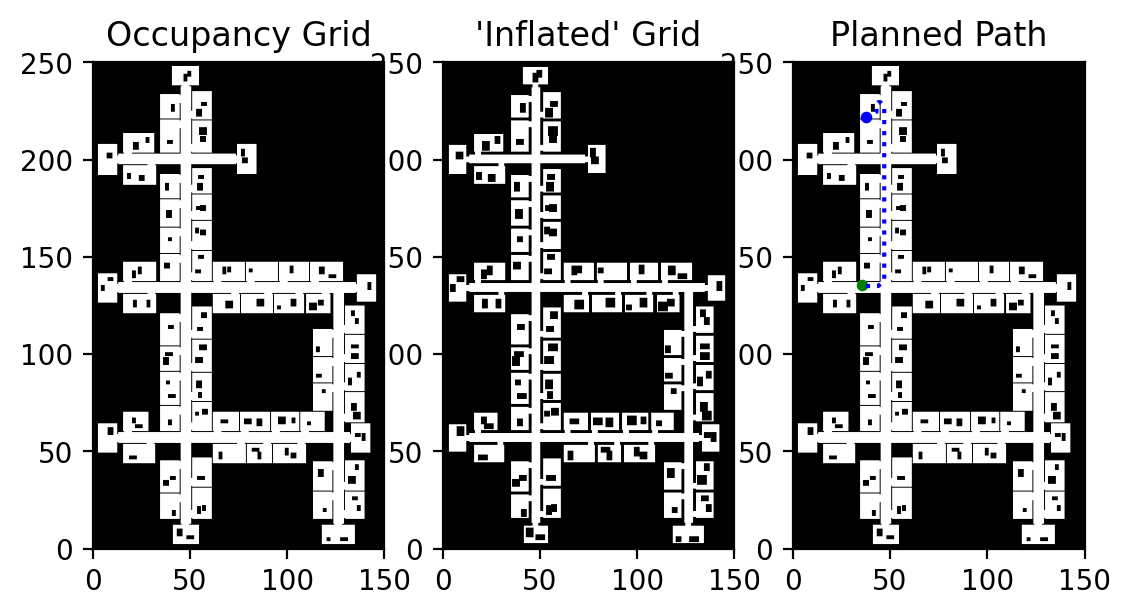

In [23]:
# Compute the inflation radius (in grid units)
inflation_radius = args.inflation_radius_m / args.base_resolution

print(f"Inflation Radius (meters): {args.inflation_radius_m}")
print(f"Inflation Radius (grid units): {inflation_radius}")

# 'Inflate' the grid; puff up the obstacles
inflated_known_grid = gridmap.utils.inflate_grid(
    known_map, inflation_radius=inflation_radius)

# Plan in the newly-inflated grid
cost_grid, get_path = gridmap.planning.compute_cost_grid_from_position(
    inflated_known_grid, [goal.x, goal.y], use_soft_cost=True)
did_plan, path = get_path([pose.x, pose.y],
                          do_sparsify=True, do_flip=True)

# Plotting
plt.figure(dpi=200)
plt.subplot(131)
lsp.utils.plotting.plot_navigation_data(
        plt.gca(), known_map, map_data=map_data)
plt.title("Occupancy Grid")

plt.subplot(132)
lsp.utils.plotting.plot_navigation_data(
        plt.gca(), inflated_known_grid, map_data=map_data)
plt.title("'Inflated' Grid")

plt.subplot(133)
lsp.utils.plotting.plot_navigation_data(
        plt.gca(), known_map, map_data=map_data, 
        robot_pose=args.base_resolution*pose,
        goal_pose=args.base_resolution*goal,
        planned_path=path)
plt.title("Planned Path")
None

Now the agent's plan looks much more reasonable.

## Putting it All Together: navigating to the goal

Now that we have a path, we should make the robot move along it! To do this, we'll instantiate a `Robot` object:

```python
robot = lsp.robot.Turtlebot_Robot(
  pose,
  primitive_length=args.step_size,
  num_primitives=args.num_primitives,
  map_data=map_data)
```

We want to robot to move along the path, which will require a loop: every time the agent moves, along the path, we should generate a new path that begins at the new location of the robot and then repeat this process until the robot is within some distance to the goal.

<div class="alert alert-block alert-info">
In principle, it is possible to only compute the path once and move the robot along it, however, in practice this will not work. First, the robot is not confined to the discrete grid we use for planning and instead follows short motion primitives that may put it slightly off the perfect path we have generated for it. Second, a real robot will not be able to perfectly execute these motion primitives to infinite precision, which means that our robot may deviate slightly from the path—continual replanning is one way to overcome this limitation. (One could also handle it on the control side; look up Pure Pursuit for details.)
</div>

By providing this robot object with a path, we can move along it and then replan from the new state, repeating this process until the goal is reached. Putting everything together, we can plan all the way to the goal:

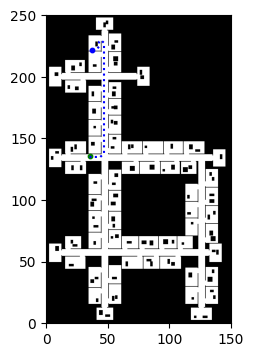

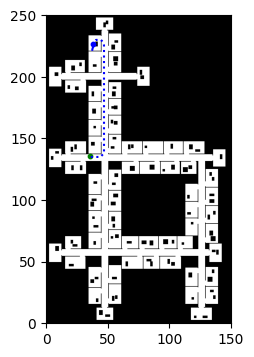

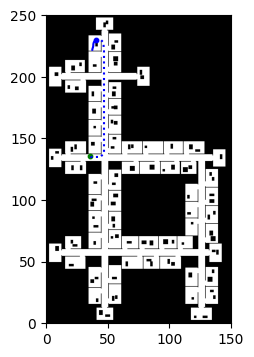

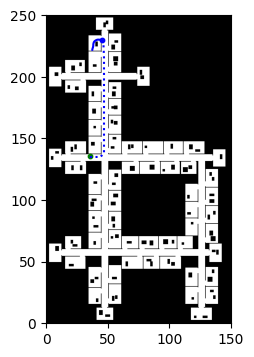

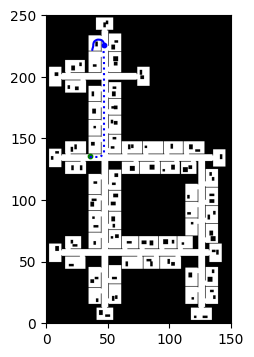

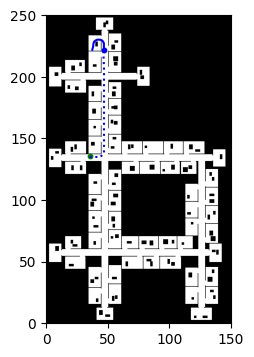

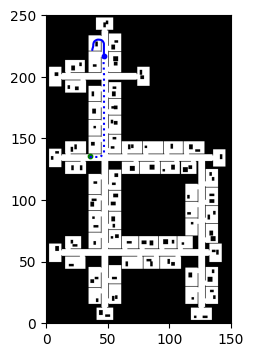

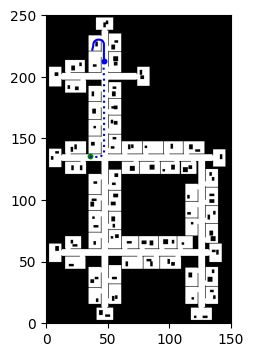

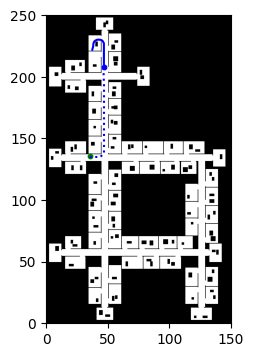

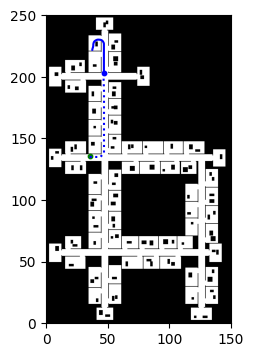

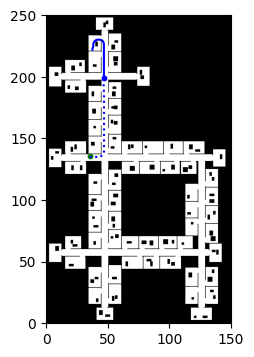

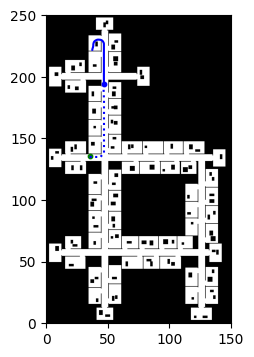

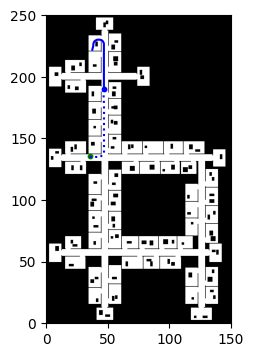

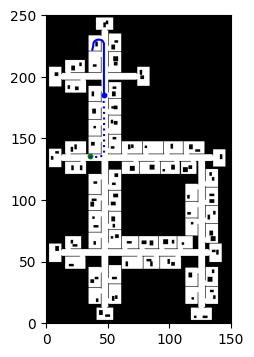

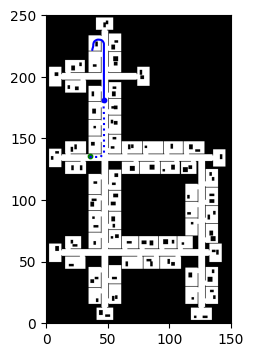

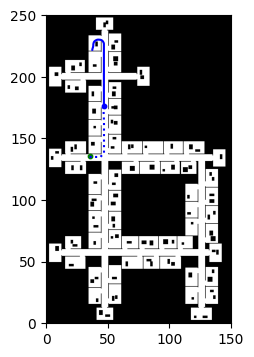

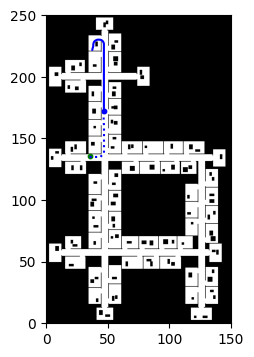

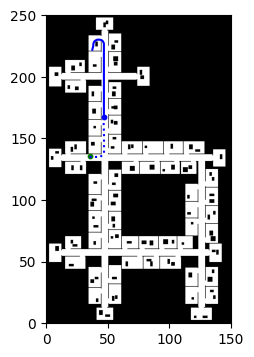

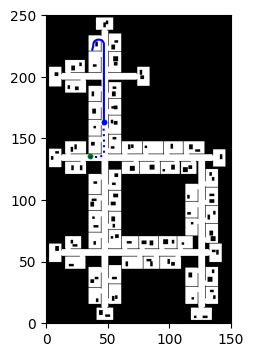

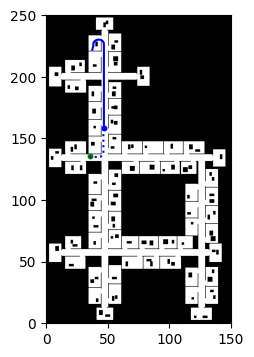

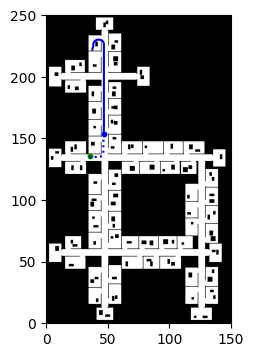

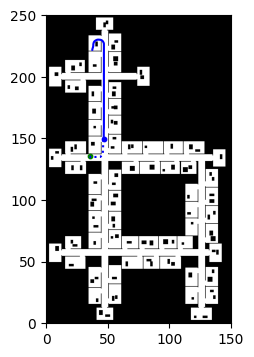

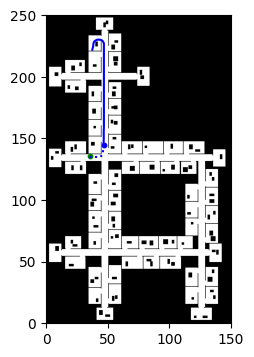

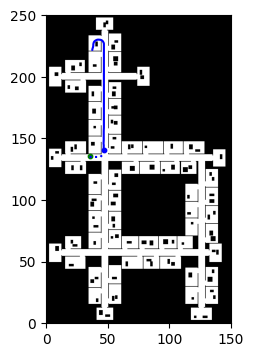

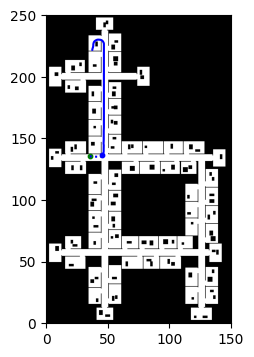

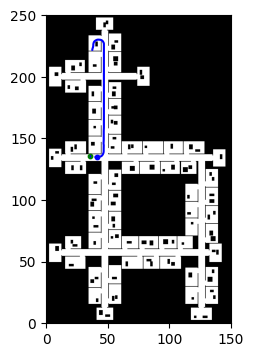

In [24]:
# Compute the inflation radius (in grid units) and apply
inflation_radius = args.inflation_radius_m / args.base_resolution
inflated_known_grid = gridmap.utils.inflate_grid(
    known_map, inflation_radius=inflation_radius)

# Define the robot
robot = lsp.robot.Turtlebot_Robot(
    pose,
    primitive_length=args.step_size,
    num_primitives=args.num_primitives,
    map_data=map_data)

counter = 0

# Planning loop: iteratively move the robot and replan
while (math.fabs(robot.pose.x - goal.x) >= 3 * args.step_size
       or math.fabs(robot.pose.y - goal.y) >= 3 * args.step_size):
    # Compute the cost grid for the current robot pose
    cost_grid, get_path = gridmap.planning.compute_cost_grid_from_position(
            inflated_known_grid, [goal.x, goal.y], use_soft_cost=True)
    did_plan, path = get_path([robot.pose.x, robot.pose.y],
                              do_sparsify=True, do_flip=True)

    # Plotting (plot every 5 steps)
    if counter % 5 == 0:
        plt.ion()
        plt.figure(1, figsize=(12, 4))
        plt.clf()

        lsp.utils.plotting.plot_navigation_data(
                plt.gca(), known_map, map_data=map_data, 
                robot_pose=robot.pose_m, 
                goal_pose=args.base_resolution*goal,
                planned_path=path,
                robot_poses=robot.all_poses)

        plt.show()

    # Get the motion primitives: primitive motions the robot can execute
    motion_primitives = robot.get_motion_primitives()
    
    # Pick the "min cost" primitive, which best moves along the path
    costs, _ = lsp.primitive.get_motion_primitive_costs(
        inflated_known_grid, cost_grid, robot.pose, path,
        motion_primitives, do_use_path=True)
    best_primitive_index = np.argmin(costs)
    
    # Move according to that primitive action
    robot.move(motion_primitives, np.argmin(costs))

    # Update counter
    counter += 1

None

# Next Steps

In [the next tutorial](./RAIL-onboarding-02-visual-simulator.ipynb), we'll explore using the *visual simulator*, which we use to generate images onboard the robot. While those images won'be be used for anything just yet, they will eventually serve as inputs to the learned models the robot uses to inform its behavior.